# Imports

In [36]:
# %matplotlib tk

In [173]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import geopandas as gpd
from shapely.geometry import Point
from shapely import Polygon
from folium.raster_layers import ImageOverlay
import io
import base64
import plotly.graph_objects as go


# from descartes import PolygonPatch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm
# from matplotlib.collections import PolyCollection  
# from matplotlib.patches import Polygon
import zarr
from mpl_toolkits.basemap import Basemap
plt.style.use('seaborn-v0_8')



from shapely.geometry import Polygon
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from matplotlib.collections import PatchCollection

# Simulation Data Loading

In [2]:
""" Load 4D ERA5 data as xarray.core.dataset.Dataset from $DATA

Some important properties
    Latitude 
        Range [44.23337936401367, 46.7599983215332] degrees North
    Longitude
        Range [-75.53164672851562, -71.8677978515625] degrees East
    Rotated Pole
        longitude, latitude [-73.57501220703125,45.5]
    Time scales:
        tas  - hourly
        tmax - daily
        q    - 3 hourly 
"""
# without TEB
tas_n = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/tas.zarr')      
tmax_n= xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/tasmax.zarr')
qn = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/huss.zarr')

# with TEB
tas_t = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/tas.zarr')
tmax_t= xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/tasmax.zarr')
qt = xr.open_zarr('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/huss.zarr')

# static fields
static_fields = xr.open_mfdataset('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_step0.nc')
urban_fraction_2d = static_fields['furban'].isel(lev=5)
lons = static_fields.lon.values
lats = static_fields.lat.values

# To account for the issue in the simulation in 2022, a slice of each dataset is loaded
tas_n = tas_n.sel(time=slice('2021'))     
tmax_n= tmax_n.sel(time=slice('2021'))
qn = qn.sel(time=slice('2021'))

# # with TEB
tas_t = tas_t.sel(time=slice('2021'))     
tmax_t= tmax_t.sel(time=slice('2021'))
qt = qt.sel(time=slice('2021'))

# Station data loading

In [4]:
# Load ECCC_AHCCD_gen3_temperature data for stations in Canada
pavics = xr.open_dataset("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/station_obs/ECCC_AHCCD_gen3_temperature.ncml")

# Restrict the selection by masking for only stations within the domain
station_is_in_domain = (
    (pavics.lat>44.23337936401367)    & 
    (pavics.lat <46.7599983215332)    & 
    (pavics.lon > -75.53164672851562) & 
    (pavics.lon < -71.8677978515625)
)

# Set the stations into a pandas dataframe
stations = pavics.sel(station=station_is_in_domain).set_coords(['lat', 'lon', 'station_name'])

# Map projection

In [5]:
# Map formatting properties for field projection
# bbox = [[44.23337936401367, -75.53164672851562], [46.7599983215332, -71.8677978515625]]

lat_min = min(lats.flatten())
lat_max = max(lats.flatten())
lon_min = min(lons.flatten())
lon_max = max(lons.flatten())

centre_lat = (lat_min + lat_max) / 2
centre_lon = (lon_min + lon_max) / 2
bounds = [[lat_min, lon_min], [lat_max, lon_max]]
extent = [lon_min, lon_max, lat_min, lat_max]

# To project station data onto the map
gdf = pd.read_pickle('polygons_gdf.pkl')
patches = [MplPolygon(np.array(poly.exterior.coords), closed=True) for poly in gdf.geometry]

station_locations = stations[['lat', 'lon', 'station_name']].to_dataframe().reset_index()
geojson_stations = gpd.GeoDataFrame(
    station_locations, geometry=gpd.points_from_xy(station_locations['lon'], station_locations['lat'])
).to_json()

In [6]:
def show_colorbar(vmin=None,vmax=None,levels=20,cmap='bwr',orientation='horizontal'
                  ,layout='constrained',label=None,adjustment = 0.):
    # Creates a colour bar with discrete categories for map using matplotlib conventions
    
    fig,ax = plt.subplots(figsize=(7,1),layout=layout)
    cmap = plt.get_cmap(cmap)
    levels += 1
    if vmin == None: vmin = 0
    if vmax == None: vmax = 1
    bounds = np.linspace(vmin,vmax,levels) -  adjustment
    norm = BoundaryNorm(bounds, cmap.N)
    fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                 cax=ax, orientation='horizontal', label=label)    

In [111]:
def draw_map(field=None,cmap_name='bwr',vmin=None,vmax=None,num_levels=None,stations_visible=False,opacity=0.8):
    """
    Creates a map and displays the station_locations within the bounds of the simulation on it. 
    It then generates an ImageOverlay of some the static field generated.
    Example usage:
        > f = tmax_n['tasmax'].sel(time='1999-03-08')
        > m = draw_map(f)
        > display(m)

    parameters:
        field - xarray.core.dataarray.DataArray
            2D temperature, humidity, or other data 
        cmap - string
            matplotlib colormap indicator
        vmin, vmax - float 
            minimum and maximum 
    returns:
        m - folium.folium.Map
    """
    
    # Initialize the map
    m = folium.Map(location=[centre_lat, centre_lon], zoom_start=8)

    folium.TileLayer('cartodb positron').add_to(m)

    if stations_visible:
        # Add station markers
        folium.GeoJson(
            geojson_stations,
            popup=folium.GeoJsonPopup(fields=['station_name'], aliases=['Station Name']),
            marker=folium.CircleMarker(radius=3, color='grey', fill=True, fill_color='grey', fill_opacity=opacity)
        ).add_to(m)

    # Overlay field data
    if field is not None:
        # Create an image to store the field data
        image_buffer = io.BytesIO()

        # Field properties
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap(cmap_name)  
        sm = ScalarMappable(cmap=cmap, norm=norm)
        
        # Create the figure to save to the map
        fig, ax = plt.subplots(figsize=(6, 6), dpi=800)
        
        bm = Basemap(projection='merc', 
            llcrnrlat=lat_min, 
            urcrnrlat=lat_max, 
            llcrnrlon=lon_min, 
            urcrnrlon=lon_max,ax=ax)

        # This works fine, but it inserts resolution where none should exist!
        # x, y = bm(lons, lats)
        # bm.contourf(x, y, field.values, cmap=cmap_name,vmin= vmin,vmax= vmax, levels=num_levels,antialiased=False)
        # XOR
        # bm.pcolormesh(x, y, field.values, cmap=cmap_name,vmin= vmin,vmax= vmax)
        
        flat_field = np.ravel(field.values)
        gdf['field'] = flat_field

        fig, ax = plt.subplots(figsize=(8, 8))
        collection = PatchCollection(
            patches,
            linewidth=0,
            edgecolor='none',
            antialiased=False
        )
        collection.set_array(gdf['field'].values)
        collection.set_cmap(cmap_name)
        collection.set_clim(vmin, vmax)
        
        
        ax.add_collection(collection)
        ax.autoscale_view()
        ax.set_aspect('equal')
        ax.axis('off')

        minx, miny, maxx, maxy = gdf.total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        # Force the canvas to layout everything
        # fig.canvas.draw()

        # Then save
        plt.savefig(image_buffer, format='png', bbox_inches='tight', pad_inches=0, transparent=True)


        
        ax.axis('off')  # Remove axes for clean image
        
        # Save image to buffer
        plt.savefig(image_buffer, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close(fig)
        plt.close()
        image_buffer.seek(0)
        image_base64 = base64.b64encode(image_buffer.read()).decode()
        image_uri = f"data:image/png;base64,{image_base64}"
        # Read image from buffer and project onto map
        ImageOverlay(
            image=image_uri,
            bounds=bounds,
            opacity=0.6,
            interactive=True,
            cross_origin=False,
            pixelated=True
        ).add_to(m)
        
    m.fit_bounds(bounds)
    return m

## Testing projection display

In [ ]:
f = tmax_n['tasmax'].sel(time='1999-03-31')
m = draw_map(f,vmin=None,vmax=None)
# m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
display(m)

In [ ]:
f = urban_fraction_2d
m = draw_map(f,vmin=-1,vmax=1,stations_visible=False)
# m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
display(m)
show_colorbar(cmap='bwr',vmin=-1,vmax=1)

## Testing polygon generation

In [ ]:
# # Load the polygon matrix
# with open('polygons_updated.pkl', 'rb') as f:
#     polygons_matrix = pickle.load(f)
# polygons_matrix

In [ ]:
# # Load the polygon matrix
# with open('polygons_updated.pkl', 'rb') as f:
#     polygons_matrix = pickle.load(f)
# polygons_matrix

In [ ]:
# gdf.to_pickle("polygons_gdf.pkl")
# gdf = pd.read_pickle("polygons_gdf.pkl")

# gdf = gpd.GeoDataFrame(geometry=flat_polygons)

# # Plot the polygons
# gdf.plot(cmap='viridis', edgecolor='black')
# plt.show()

In [ ]:
# field = tmax_n['tasmax'].sel(time='1999-03-31')
# flat_field = np.ravel(field.values)
# gdf["field"] = flat_field

In [ ]:
# coords = [np.array(poly.exterior.coords) for poly in gdf.geometry]

# with open("polygon_coords.pkl", "wb") as f:
#     pickle.dump(coords, f)

# Humidity considerations

In [ ]:
"""
Calculate the 2D summer maximum daily 2m relative humidity field in time 
    1. Extract the 2D temperature field corresponding for each 3 hour 2m absolute humidity record 
    2. Mask humidity values for only summer
    3. Apply saturation vapour pressure formula from Huang (2018)
"""

# 3 hour summer 2m temperature record to have equivalent sampling record
tas_3h_summer_n = tas_n.groupby('time.season')['JJA'].resample(time='3h').nearest()

In [8]:
def SVP(T):
    """
    Calculates the saturation vapour pressure values according to Huang (2018)
    
    parameters
        T : numpy.float32
            Temperature [K]
    returns
        e_s : numpy.float32
            Saturation vapour pressure for a given T in Pa
    """
    t = T - 273.15
    e_s = 0.
    # if t <= 0: # SVP of ice
        # e_s = np.exp(43.494 - 6545.8/(t + 278)) / np.square(t+868)
    # else: # SVP of water
    e_s = np.exp(34.494 - 4924.99/(t+ 237.1)) / np.power(t+105,1.57)
    return e_s

def VP(T,q):
    """
    Approximates the actual vapour pressure using the ideal gas law

    parameters
        T : numpy.float32
            Temperature [K]
        q : numpy.float32
            Specific humidity [kg/kg]
    returns
          : numpy.float32
            Actual partial pressure of vapour in Pa
    """
    M_v = 0.01802 #kg/mol molar mass of water
    R = 8.314 #J/(mol K) ideal gas constant
    rho_d = 1.293 #kg/m^2 density of dry air
    e = 0.
    q = np.abs(q)
    
    # if q!=0:
    e = (q*rho_d*R*T) / ((1-q)*M_v)
    return e
    
    

In [70]:
def humidex(e,T):
    """
    Index to indicate how hot or humid the weather feels to the average person according to ECCC technical documentation
    
    params
        e : float
            Vapour pressure [Pa]
        T : float
            Temperature [K]
    returns
        hdx : float 
            Humidex [C]
    """
    return (T - 273.15) + (0.5555)*(e/100 - 10.0)
    

## Focus on summertime values

In [74]:
# Extraction of the tasmax_n, maximum daily t
tmax_n_summer = tmax_n.groupby('time.season')['JJA']
qn_summer = qn.groupby('time.season')['JJA']
vps = VP(tas_3h_summer_n['tas'],qn_summer['huss'])
svps = SVP(tas_3h_summer_n['tas'])
RH_n_summer = vps/svps
RH_max = RH_n_summer.resample(time='1D').max()
RH_max_bar = RH_max.mean(dim='time')
RH_bar = RH_n_summer.mean(dim='time')
# 3-hour humidex data according to ECCC technical documentation
hdx = humidex(RH_n_summer,tas_3h_summer_n['tas'])
hdx_bar = hdx.mean(dim='time')
hdx_max = hdx.resample(time='1D').max()
hdx_max_bar = hdx_max.mean(dim='time')
tasmax_bar = tmax_n_summer['tasmax'].mean(dim='time')
tas_summer = tas_n['tas'].groupby('time.season')['JJA']

## Testing map functionality

In [ ]:
# f = tasmax_bar
# m = draw_map(f,stations_visible=False)
# # m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
# display(m)

In [ ]:
# f = hdx_bar
# m = draw_map(f,stations_visible=False)
# # m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
# display(m)

In [ ]:
# f = RH_max_bar
# m = draw_map(f,stations_visible=False)
# # m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
# display(m)

In [ ]:
# f = hdx_max_bar
# m = draw_map(f,stations_visible=False)
# # m.save('/home/gulley/urban_heat_waves/tasmax_1999-03-31.html')
# display(m)

# Urban Fraction Masks

In [118]:
is_urban = urban_fraction_2d>= 0.6
is_suburban = (urban_fraction_2d<=0.3) & (urban_fraction_2d <0.6)
is_rural = urban_fraction_2d < 0.3

In [ ]:
"""
Plot the urban fraction
"""
f = urban_fraction_2d
cmap = 'viridis'
vmin = min(np.ravel(f))
vmax = max(np.ravel(f))

show_colorbar(cmap=cmap,vmin=vmin,vmax=vmax)
display(draw_map(f,cmap_name = cmap))

In [145]:
# Extract time series binned by urban fraction for daily summer maximum temperature, humidity, humidex
time_series = {'humidex':{'urban':None,'rural':None,'suburban':None},
               'temperature':{'urban':None,'rural':None,'suburban':None},
               'humidity':{'urban':None,'rural':None,'suburban':None}}

In [181]:
for field in ['temperature','humidity','humidex']:
    for urban_level in ['urban','suburban','rural']:
        try: # Due to some sloppy naming conventions when saving dataarrays, I've put in this try statement
            time_series[field][urban_level] = xr.open_zarr(f'time_series_{field}_{urban_level}.zarr')['__xarray_dataarray_variable__']
        except: 
            time_series[field][urban_level] = xr.open_zarr(f'time_series_{field}_{urban_level}.zarr')['tas'] - 273.15

# Diurnal Cycles

In [211]:
diurnal_cycles= {'humidex':{'urban':None,'rural':None,'suburban':None},
                 'temperature':{'urban':None,'rural':None,'suburban':None},
                 'humidity':{'urban':None,'rural':None,'suburban':None}}

for field in ['temperature','humidity','humidex']:
    for urban_level in ['urban','suburban','rural']:
        diurnal_cycles[field][urban_level] = time_series[field][urban_level].groupby('time.hour').mean(dim='time')

In [212]:
# Small correction to temp, humidity, and humidex to ensure they're connected in the complete cycle
# 3-hour seems to have excluded some things
for field in ['humidity', 'humidex', 'temperature']:
    for urban_level in ['urban', 'suburban', 'rural']:
        da = diurnal_cycles[field][urban_level]
        first_point = da.isel(hour=0).expand_dims(hour=[24])
        diurnal_cycles[field][urban_level] = xr.concat([da, first_point], dim='hour')

# Humidity graphs better as a percentage
for urban_level in ['urban','suburban','rural']:
    diurnal_cycles['humidity'][urban_level] = diurnal_cycles['humidity'][urban_level]*100

In [176]:
# for field in ['temperature','humidity','humidex']:
#     for urban_level in ['urban','suburban','rural']:


Coordinates:
    lev      float64 8B ...
  * hour     (hour) int64 64B 0 3 6 9 12 15 18 21

In [222]:
linestyle_map = {'temperature':'firebrick',
                 'humidity':'royalblue',
                 'humidex': 'magenta',
                 'urban':3,
                 'suburban':2,
                 'rural':1}

dash_map = {'urban':'solid',
             'suburban':'dash',
             'rural':'dot'}

axis_map = {'temperature':'y1',
            'humidity': 'y2',
            'humidex': 'y1'}
fig = go.Figure()

for field in ['temperature','humidity','humidex']:
    for urban_level in ['urban','rural']:
        fig.add_trace(go.Scatter(
            x=diurnal_cycles[field][urban_level].coords['hour'],
            y=diurnal_cycles[field][urban_level],
            name=f'{urban_level.capitalize()} {field.capitalize()}',
            yaxis=axis_map[field],
            line=dict(color=linestyle_map[field], width=linestyle_map[urban_level],dash=dash_map[urban_level])
))


# Layout with two y-axes
fig.update_layout(
    title='Summer Diurnal Heat Cycles',
    xaxis=dict(title='Time - UTZ ',
              range=[0,24]),
    yaxis=dict(
        title='Temperature (C)'
    ),
    yaxis2=dict(
        title='Humidity (%)',
        overlaying='y',
        side='right'
    ),
    
    legend=dict(
        orientation='h',    
        yanchor='bottom',
        y=-0.35, # Just below the plot             
        xanchor='center',
        x=0.5
    ),
    
    template='plotly_white'
)

# fig.show()
# fig.save('Summer_Diurnal_Heat_Cycle.html')
fig.write_html('Summer_Diurnal_Heat_Cycle.html')

# Time-averaged field anomaly definition

In [88]:
"""
To calulate the summer month averages - these will be spatial fields (i.e. the averages in time.)
    1. The base case includes all years over the time period
    2. Only PNA- years to give PNA- anomalies
    3. Only PNA+ years  to give PNA+ anomalies
From this, we can subtract the values determined in cases 2 and 3 for the anomaly forcing of the PNA
We must do this for each temperature, humidity, and heat stress

Also consider a typical diurnal cycle for heat and the three-hour temperatures relating the PNA mask
"""
humidex_avg = xr.open_zarr('hdx_max_bar.zarr')['__xarray_dataarray_variable__']
humidity_avg = xr.open_zarr('RH_max_bar.zarr')['__xarray_dataarray_variable__']
tasmax_avg = xr.open_zarr('tasmax_bar')['tasmax']

## Typical maximum daily summer fields


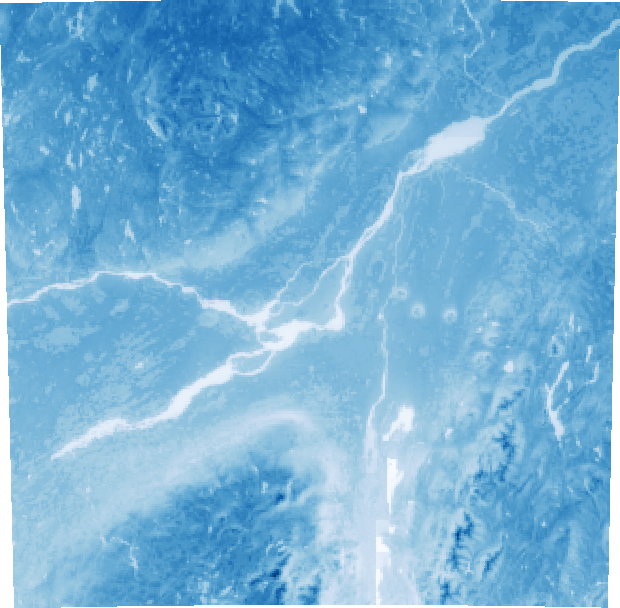

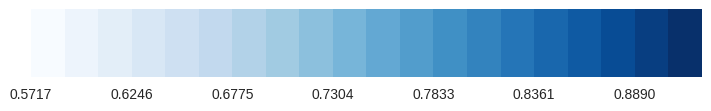

In [61]:
"""
Average maximum daily summer humidity field
"""
f= humidity_avg
cmap= 'Blues'

vmax = max(np.ravel(f.values))
vmin = min(np.ravel(f.values))

m = draw_map(f, vmin= vmin, vmax = vmax, cmap_name = cmap)
show_colorbar(vmin= vmin,vmax = vmax, cmap= cmap)
display(m)


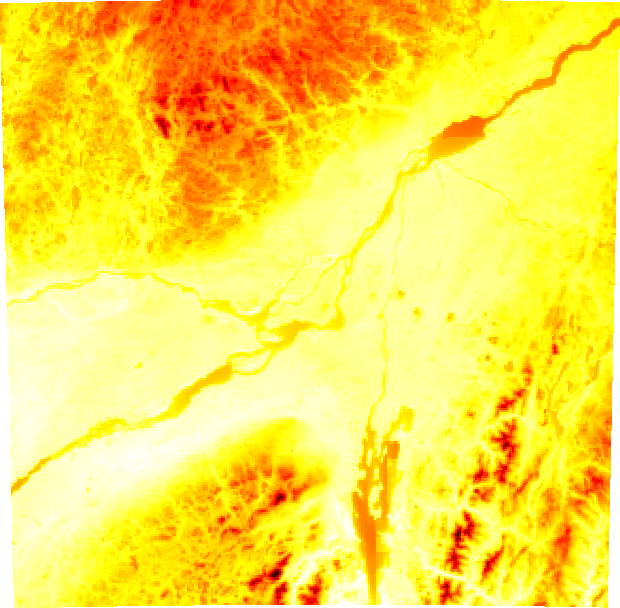

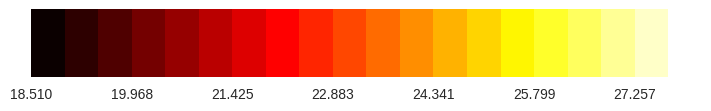

In [57]:
"""
Average maximum daily summer temperature field
"""
f = tasmax_avg
vmax = max(np.ravel(f.values))
vmin = min(np.ravel(f.values))

m = draw_map(f, vmin= vmin, vmax = vmax, cmap_name = 'hot')
show_colorbar(vmin= vmin,vmax = vmax, cmap= 'hot',adjustment=273.15)
display(m)


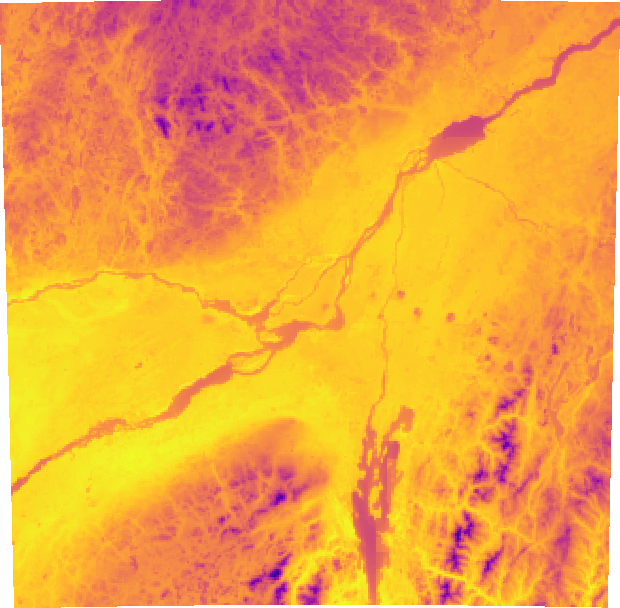

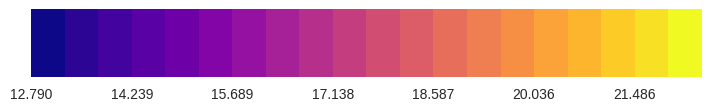

In [89]:
"""
Average maximum daily summer humidex field
    **This should be taken against the daily max summer temperature field with a grain of salt 
    (due to different sampling frequencies 3-hr vs 1-hr) 
    ** this goes to show why anomalies are so important!
    
    *** It may be prudent to later interpolate maximum daily humidity values between 
"""
f = humidex_avg
cmap = 'plasma'

vmax = max(np.ravel(f.values))
vmin = min(np.ravel(f.values))

m = draw_map(f, vmin= vmin, vmax = vmax, cmap_name = cmap)
show_colorbar(vmin= vmin,vmax = vmax, cmap= cmap)
display(m)

# PNA Masks

In [80]:
# Now to load the PNA dataset for masking PNA+ and PNA- years
pna = pd.read_csv('/runoff/gulley/scripts/dataFiles/NOAA_PNA_index_1999_2023.csv')
pna.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
pna.set_index('Year', inplace=True)
summer_pna = pna[['Jun','Jul','Aug']]

In [87]:
summer_pna

,Jun,Jul,Aug
Year,,,
1999,0.30,-0.54,1.97
2000,-1.22,-2.28,-0.48
2001,-0.94,0.06,-0.11
2002,-0.05,0.88,0.64
2003,-0.60,1.23,-0.28
2004,-0.37,0.09,1.55
2005,0.29,0.43,0.72
2006,-1.06,1.83,-1.41
2007,-0.38,2.21,1.98


# Data saving

In [155]:
# Form for loading is straightforward
# dataset = xr.open_zarr('path/to/variable.zarr')

In [ ]:
"""
Some old code to ensure variables persist, lots of problems of course :)

"""
# # hdx_max_bar.to_zarr('hdx_max_bar.zarr', mode='w')
# # hdx.to_zarr('hdx.zarr', mode='w')
# hdx_bar.to_zarr('hdx_bar.zarr',mode='w')
# # hdx_max.to_zarr('hdx_max.zarr', mode='w')

# RH_max_bar.to_zarr('RH_max_bar.zarr', mode='w')
# # RH_max.to_zarr('RH_max.zarr', mode='w')
# RH_bar.to_zarr('RH_bar.zarr',mode='w')
# # RH.to_zarr('RH.zarr', mode='w')

# tasmax_bar.to_zarr('tasmax_bar.zarr',mode='w')


# # svps.to_zarr('svps.zarr',mode='w')
# # vps.to_zarr('vps.zarr',mode='w')
# # tas_3h_summer_n.to_zarr('tas_3h.zarr',mode='w')


"""
Original time_series loading, now saved, can be loaded by loop

"""

# time_series['humidex']['urban'] = hdx.where(is_urban).mean(dim=['rlat','rlon'])
# time_series['humidex']['suburban'] = hdx.where(is_suburban).mean(dim=['rlat','rlon'])
# time_series['humidex']['rural'] = hdx.where(is_rural).mean(dim=['rlat','rlon'])

# time_series['temperature']['urban'] = tas_summer.where(is_urban).mean(dim=['rlat','rlon'])
# time_series['temperature']['suburban'] = tas_summer.where(is_suburban).mean(dim=['rlat','rlon'])
# time_series['temperature']['rural'] = tas_summer.where(is_rural).mean(dim=['rlat','rlon'])

# time_series['humidity']['urban'] = RH_n_summer.where(is_urban).mean(dim=['rlat','rlon'])
# time_series['humidity']['suburban'] = RH_n_summer.where(is_suburban).mean(dim=['rlat','rlon'])
# time_series['humidity']['rural'] = RH_n_summer.where(is_rural).mean(dim=['rlat','rlon'])
# for field in ['temperature','humidity','humidex']:
#     for urban_level in ['urban','suburban','rural']:
#         time_series[field][urban_level].to_zarr(f'time_series_{field}_{urban_level}.zarr', mode='w')